Combine the results of notebooks:

"27. psf measurement evaluation - part 2"<br>
"27. psf measurement evaluation - part 3"<br>
"28. algorithm shootout - updated"<br>

We will generate images with increasing densities, fit their PSFs, and then evaluate A&L and ZOGY on those images.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


In [2]:
import diffimTests as dit
reload(dit)

No module named utils
No module named utils


<module 'diffimTests' from 'diffimTests.pyc'>

In [3]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

In [4]:
sky = 300.

def runTest(n_sources=500, seed=66, n_varSources=10, flux=1500., scintillation=0.05):
    out = None
    try:
        testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., 
                             #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), scintillation=scintillation,
                             seed=seed, psfSize=21)
        
        try:
            testRes1 = testObj.runTest(zogyImageSpace=False)
        except:
            testRes1 = None
        
        try:
            actualPsf1 = testObj.im1.psf.copy() #dit.makePsf(21, [1.6, 1.6], offset=[0., 0.], theta=0.)
            im1 = testObj.im1.asAfwExposure()
            res1 = dit.measurePsf(im1, detectThresh=5.0, measurePsfAlg='psfex')
            psf1 = dit.afwPsfToArray(res1.psf, im1) #.computeImage()
            psf1a = psf1.copy() #/ np.abs(psf2.getArray()).sum()
            psf1anorm = psf1a[np.abs(psf1a)>=1e-3].sum()
            psf1a /= psf1anorm
            rms1 = np.sqrt(((psf1a - actualPsf1)**2.).mean()) #* 100.
            normedRms1 = computeNormedPsfRms(psf1a, actualPsf1)
            sh = dit.arrayToAfwPsf(actualPsf1).computeShape()
            inputShape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res1.psf, im1)
            shape1 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments1 = dit.computeMoments(psf1)
        except Exception as e:
            #print e
            psf1 = rms1 = shape1 = moments1 = inputShape1 = normedRms1 = None

        try:
            actualPsf2 = testObj.im2.psf.copy() #dit.makePsf(21, [1.8, 2.2], offset=[0., 0.], theta=-45.)
            im2 = testObj.im2.asAfwExposure()
            res2 = dit.measurePsf(im2, detectThresh=5.0, measurePsfAlg='psfex')
            psf2 = dit.afwPsfToArray(res2.psf, im2) #.computeImage()
            psf2a = psf2.copy() #/ np.abs(psf2.getArray()).sum()
            psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
            psf2a /= psf2anorm
            rms2 = np.sqrt(((psf2a - actualPsf2)**2.).mean()) #* 100.
            normedRms2 = computeNormedPsfRms(psf2a, actualPsf2)
            sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
            inputShape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            sh = dit.afwPsfToShape(res2.psf, im2)
            shape2 = [sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()]
            moments2 = dit.computeMoments(psf2)
        except Exception as e:
            #print e
            psf2 = rms2 = shape2 = moments2 = inputShape2 = normedRms2 = None

        try:
            testObj.reset()
            psf1b = psf1a.copy()
            psf1b[psf1b < 0] = 0
            psf1b[0:10,0:10] = psf1b[31:41,31:41] = 0
            psf1b /= psf1b.sum()
            psf2b = psf2a.copy()
            psf2b[psf2b < 0] = 0
            psf2b[0:10,0:10] = psf2b[31:41,31:41] = 0
            psf2b /= psf2b.sum()
            testObj.im1.psf = psf1b
            testObj.im2.psf = psf2b
            testRes2 = testObj.runTest(zogyImageSpace=False)
        except:
            testRes2 = None

        out = {'psf1': psf1, 'psf2': psf2,
               'inputPsf1': actualPsf1, 'inputPsf2': actualPsf2,
               'rms1': rms1, 'rms2': rms2, 
               'shape1': shape1, 'shape2': shape2,
               'inputShape1': inputShape1, 'inputShape2': inputShape2,
               'moments1': moments1, 'moments2': moments2,
               'nSources': n_sources, 'seed': seed,
               'diffimResInputPsf': testRes1, 'diffimResMeasuredPsf': testRes2,
               'normedRms1': normedRms1, 'normedRms2': normedRms2}
    except Exception as e:
        #print e
        pass
    return out

In [90]:
tmp = runTest(n_sources=50, seed=1);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 2, 'FP': 1, 'TP': 8},
  'ALstack_noDecorr': {'FN': 0, 'FP': 1, 'TP': 10},
  'SZOGY': {'FN': 0, 'FP': 0, 'TP': 10},
  'ZOGY': {'FN': 0, 'FP': 3, 'TP': 10}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 2, 'FP': 1, 'TP': 8},
  'ALstack_noDecorr': {'FN': 0, 'FP': 1, 'TP': 10},
  'SZOGY': {'FN': 0, 'FP': 0, 'TP': 10},
  'ZOGY': {'FN': 0, 'FP': 1, 'TP': 10}},
 'inputShape1': [1.5999732062394578,
  2.5599142606841707,
  2.5599142606841707,
  0.0],
 'inputShape2': [1.989961637274519,
  4.039946238041112,
  4.039946238041112,
  -0.799989278877403],
 'moments1': (19.974399192401478, 19.971351185638323),
 'moments2': (20.014405318780582, 19.978618255461924),
 'nSources': 50,
 'normedRms1': 0.0032390144035837048,
 'normedRms2': 0.0072893012882391606,
 'rms1': 0.00017491629430296839,
 'rms2': 0.00016271063450999423,
 'seed': 1,
 'shape1': [1.6015721310985926,
  2.5687429295782893,
  2.5613361555234,
  -0.0042843042275328555],
 'shape2': [1.991859926473931,
 

In [91]:
tmp = runTest(n_sources=4500, seed=2);
del tmp['inputPsf1'], tmp['inputPsf2'], tmp['psf1'], tmp['psf2']
tmp

{'diffimResInputPsf': {'ALstack': {'FN': 4, 'FP': 11, 'TP': 6},
  'ALstack_noDecorr': {'FN': 3, 'FP': 15, 'TP': 7},
  'SZOGY': {'FN': 5, 'FP': 330, 'TP': 5},
  'ZOGY': {'FN': 3, 'FP': 23, 'TP': 7}},
 'diffimResMeasuredPsf': {'ALstack': {'FN': 4, 'FP': 7, 'TP': 6},
  'ALstack_noDecorr': {'FN': 3, 'FP': 14, 'TP': 7},
  'SZOGY': {'FN': 10, 'FP': 228, 'TP': 0},
  'ZOGY': {'FN': 10, 'FP': 44, 'TP': 0}},
 'inputShape1': [1.5999732062394578,
  2.5599142606841707,
  2.5599142606841707,
  0.0],
 'inputShape2': [1.989961637274519,
  4.039946238041112,
  4.039946238041112,
  -0.799989278877403],
 'moments1': (20.539978417371337, 20.479149708150786),
 'moments2': (19.350143905318859, 19.581717325643456),
 'nSources': 4500,
 'normedRms1': 0.013142730224712809,
 'normedRms2': 0.037473283895519044,
 'rms1': 0.00074707000388210922,
 'rms2': 0.0019955804938862082,
 'seed': 2,
 'shape1': [1.6344326950058372,
  2.652591407802162,
  2.6902848077620583,
  0.0027268692923326583],
 'shape2': [2.1638831000791

In [92]:
#inputs = [(i, j) for i in np.insert(np.arange(50, 5000, 100), 0, [5,10,25,35]) for j in np.arange(1, 10)]
inputs = [(i, j) for i in np.insert(np.arange(200, 5000, 200), 0, [5,10,25,35,50,100,150]) for j in np.arange(1, 25)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1]) \
                                                     for i in inputs)
import cPickle; import gzip
cPickle.dump(testResults1, gzip.GzipFile('28. algorithm shootout - vs stellar density using measured PSFs.p.gz', 'wb'))

744


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   59.9s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 14.6min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 72.1min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 178.8min
[Parallel(n_jobs=3)]: Done 744 out of 744 | elapsed: 215.9min finished


744 695


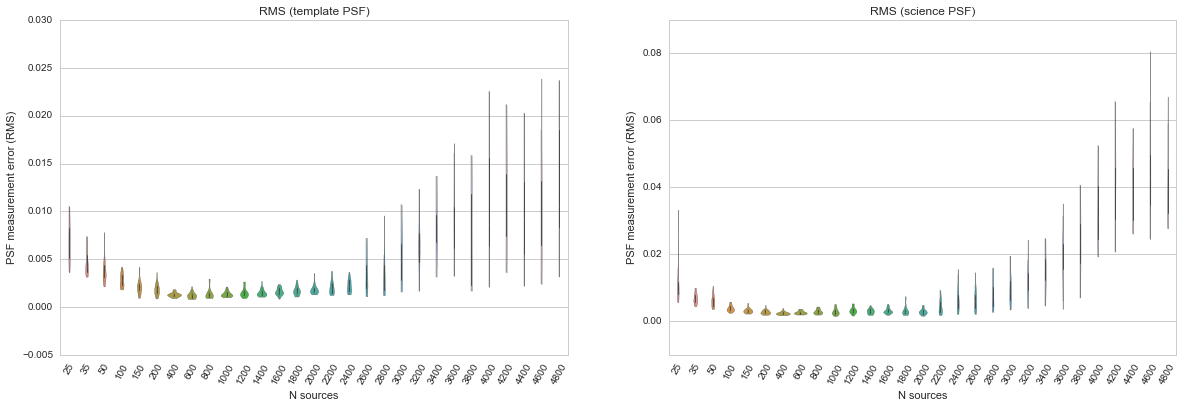

In [118]:
ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults1[i] is not None])
tr = [t for t in testResults1 if t is not None and t['inputPsf1'] is not None and t['psf1'] is not None]
tr = [t for t in tr if t is not None and t['inputPsf2'] is not None and t['psf2'] is not None]
#tr = [t for t in tr if t is not None and t['psf1'] is not None]
#tr = [t for t in tr if t['rms1'] is not None]
#tr = [t for t in tr if t['rms2'] is not None]
print len(testResults1), len(tr)
ns = np.array([t['nSources'] for t in tr if t is not None])
rms1s = [computeNormedPsfRms(t['psf1'], t['inputPsf1']) for t in tr if t is not None]
rms2s = [computeNormedPsfRms(t['psf2'], t['inputPsf2']) for t in tr if t is not None]

tr = {'nSources': ns,
      #'rms1': np.array([t['rms1'] for t in tr])*100.,
      #'rms2': np.array([t['rms2'] for t in tr])*100.,
      #'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
      #'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])
     }
tr = pd.DataFrame(tr)

tr['rms1'] = np.array(rms1s)
tr['rms2'] = np.array(rms2s)

matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0])
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1])
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

In [25]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    tr = [t for t in tr if t is not None]
    tr = [t for t in tr if t is not None and t['diffimResMeasuredPsf']]
    TP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t['diffimResMeasuredPsf'][key]['FP'] for t in tr]) for key in methods})

    TP['nSources'] = np.array([t['nSources'] for t in tr])
    FP['nSources'] = np.array([t['nSources'] for t in tr])
    FN['nSources'] = np.array([t['nSources'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (24.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['nSources', methods[0]]]
    tmp2 = TP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0], scale='width')
    g.set_title('True Positives')
    g.set_ylim((0, 10))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['nSources', methods[0]]]
    tmp2 = FP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))

    g = sns.violinplot(x='nSources', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], width=1.2, scale='width')
    g.set_title('False Positives')
    g.set_ylim((0, 100))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);
    
methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

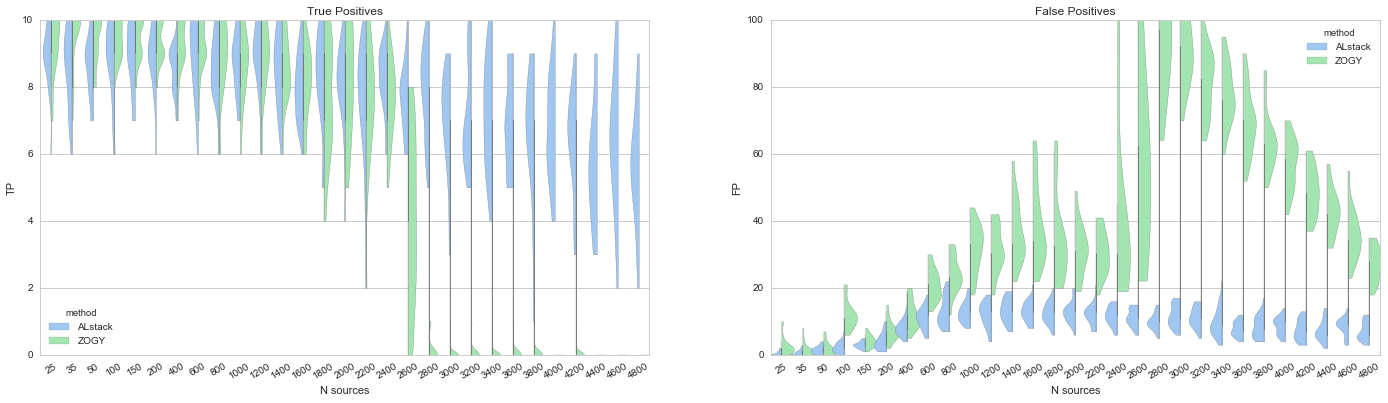

In [26]:
#testResults1 = cPickle.load(gzip.GzipFile('28. algorithm shootout - vs stellar density using measured PSFs.p.gz', 'rb'))
plotResults(testResults1, methods=['ALstack', 'ZOGY'])

### Re-do it with NO scintillation.

Above was with 0.05 pixel scintillation. Zeljko suggested that scintillation should be at or below 1 mas, or 0.005 pixels (pixel scale 0.2 arcsec/pixel)

In [5]:
inputs = [(i, j) for i in np.insert(np.arange(200, 5000, 200), 0, [5,10,25,35,50,100,150]) for j in np.arange(1, 25)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(n_sources=i[0], seed=i[1], scintillation=0.) \
                                                     for i in inputs)
import cPickle; import gzip
cPickle.dump(testResults2, gzip.GzipFile('28. algorithm shootout - vs stellar density using measured PSFs 2.p.gz', 'wb'))

744


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 16.2min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 77.8min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 193.1min
[Parallel(n_jobs=3)]: Done 744 out of 744 | elapsed: 234.4min finished


744 695


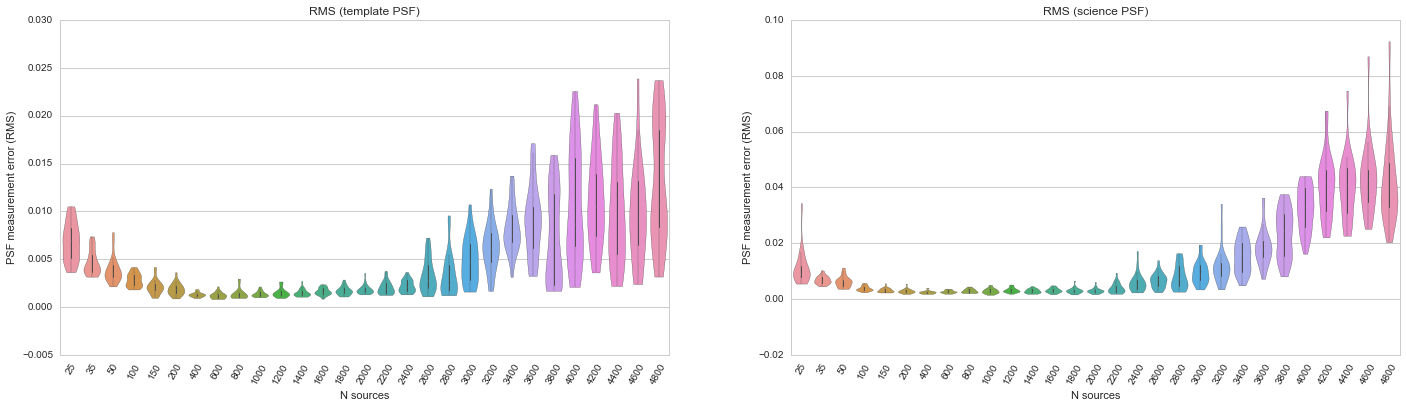

In [23]:
ns = np.array([inputs[i][0] for i in np.arange(len(inputs)) if testResults2[i] is not None])
tr = [t for t in testResults2 if t is not None and t['inputPsf1'] is not None and t['psf1'] is not None]
tr = [t for t in tr if t is not None and t['inputPsf2'] is not None and t['psf2'] is not None]
#tr = [t for t in tr if t is not None and t['psf1'] is not None]
#tr = [t for t in tr if t['rms1'] is not None]
#tr = [t for t in tr if t['rms2'] is not None]
print len(testResults2), len(tr)
ns = np.array([t['nSources'] for t in tr if t is not None])
rms1s = [computeNormedPsfRms(t['psf1'], t['inputPsf1']) for t in tr if t is not None]
rms2s = [computeNormedPsfRms(t['psf2'], t['inputPsf2']) for t in tr if t is not None]

tr = {'nSources': ns,
      #'rms1': np.array([t['rms1'] for t in tr])*100.,
      #'rms2': np.array([t['rms2'] for t in tr])*100.,
      #'rad1diff': np.array([t['shape1'][0] - t['inputShape1'][0] for t in tr]),
      #'rad2diff': np.array([t['shape2'][0] - t['inputShape2'][0] for t in tr])
     }
tr = pd.DataFrame(tr)

tr['rms1'] = np.array(rms1s)
tr['rms2'] = np.array(rms2s)

matplotlib.rcParams['figure.figsize'] = (24.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

g = sns.violinplot(x='nSources', y='rms1', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[0],
                  scale='width')
g.set_title('RMS (template PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

g = sns.violinplot(x='nSources', y='rms2', data=tr, inner="box", cut=0, linewidth=0.3, bw=0.5, ax=axes[1],
                  scale='width')
g.set_title('RMS (science PSF)')
g.set_ylabel('PSF measurement error (RMS)')
g.set_xlabel('N sources')
g.set_xticklabels(g.get_xticklabels(), rotation=60);

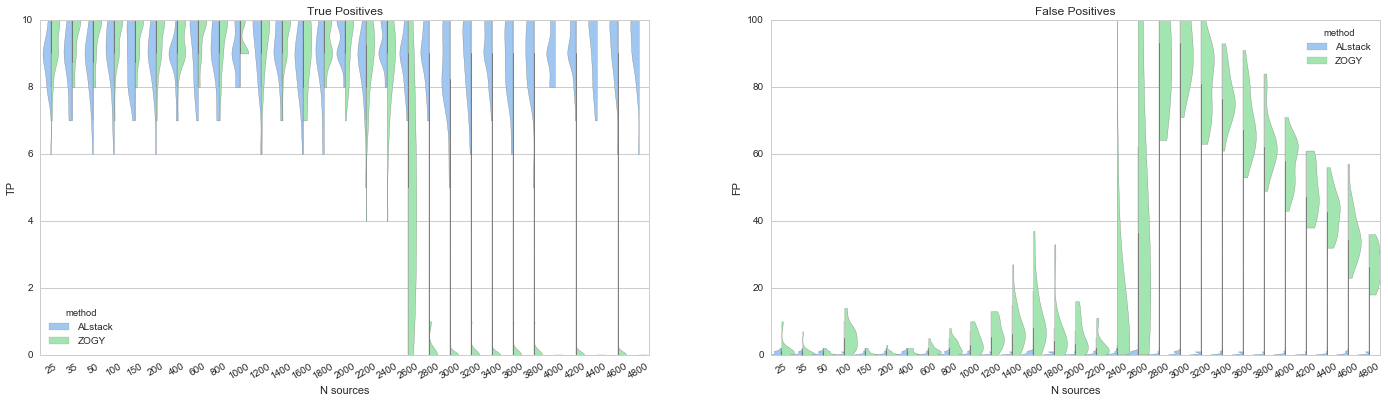

In [27]:
plotResults(testResults2, methods=['ALstack', 'ZOGY'])